In [1]:
import pandas as pd
import numpy as np
from time_series_transform.tensorflow_adopter import *
import time_series_transform.base as base
from time_series_transform.time_series_transformer import *
from sklearn.preprocessing import StandardScaler
from time_series_transform.tensorflow_adopter import *
from time_series_transform.stock_transform.base import *
from time_series_transform.util import *

In [2]:
df = pd.read_csv('./Data/Stock/sp.csv')
df2 = pd.read_csv('./Data/Stock/GOOGL.csv')
stock1 = Stock('sp500',df)
stock2 = Stock('googl',df2)
port = Portfolio([stock1,stock2])

In [3]:
port.make_technical_indicator('Close','fft10000',rfft_transform,threshold = 10000)
port.make_technical_indicator('Close','fft100',rfft_transform,threshold = 1000)

In [4]:
port.stockDict

{'sp500': <time_series_transform.stock_transform.base.Stock at 0x27ff00791d0>,
 'googl': <time_series_transform.stock_transform.base.Stock at 0x27fe4ef2400>}

In [6]:
port.plot(['sp500'],['Close'],True)

TypeError: list indices must be integers or slices, not str

In [7]:
df = port.get_portfolio_dataFrame()
df[df.symbol == 'googl']

,Date,Open,High,Low,Close,Adj Close,Volume,Close_fft10000,Close_fft100,symbol
0,2015-07-09,548.650024,548.880005,544.619995,544.650024,544.650024,1488300,NaN,NaN,googl
1,2015-07-10,553.710022,559.289978,552.000000,556.109985,556.109985,2171800,878.212979,1017.228608,googl
2,2015-07-13,559.510010,572.849976,558.700012,571.729980,571.729980,2089600,620.778629,991.640138,googl
3,2015-07-14,574.500000,589.710022,574.169983,584.179993,584.179993,3741600,488.304048,966.398761,googl
4,2015-07-15,583.739990,588.690002,580.210022,583.960022,583.960022,2073300,490.981304,941.589957,googl
...,...,...,...,...,...,...,...,...,...,...
1254,2020-07-01,1419.170044,1448.479980,1414.180054,1442.000000,1442.000000,2109100,1462.921312,1147.161783,googl
1255,2020-07-02,1451.839966,1488.520020,1451.069946,1469.930054,1469.930054,2860900,1548.587123,1121.228362,googl
1256,2020-07-06,1488.150024,1510.000000,1476.979980,1499.650024,1499.650024,2235600,1558.823839,1095.170789,googl
1257,2020-07-07,1496.130005,1521.319946,1489.699951,1489.920044,1489.920044,2118200,1435.656190,1069.087418,googl


In [5]:
trainDate = list(range(4000,4800))
valDate = list(range(4800,4900))
testDate = list(range(4900,5000))
labels = [
    'sp500_Close_fft10000',
    'sp500_Close_fft100',
    'googl_Close_fft10000',
    'googl_Close_fft100',
    'googl_Close',
    'sp500_Close'
         ]
WINDOW_SIZE = 20

In [6]:
resDf = port.get_portfolio_dataFrame()
psd = Pandas_Time_Series_Tensor_Dataset(resDf)
timeSeriesDic = psd.expand_dataFrame_by_date('symbol','Date',True,False,True)
for i,v in enumerate(labels):
    if i == 0:
        psd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',trainDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',trainDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
        
psd.set_config(
    name = 'label',
    colNames = list(map(lambda x: f'sp500_Close_{str(x)}',trainDate)),
    tensorType = 'label',
    sequence_stack = None,
    isResponseVar = True,
    windowSize = WINDOW_SIZE,
    seqSize = 1837,
    outType = np.float32
)

In [7]:
gen = psd.make_data_generator()
tfg = TFRecord_Writer('abc.tfRecord')
tfg.write_tfRecord(gen)
dtypeRecord_train = tfg.get_tfRecord_dtype()

In [8]:
psd = Pandas_Time_Series_Tensor_Dataset(resDf)
timeSeriesDic = psd.expand_dataFrame_by_date('symbol','Date',True,False,True)
for i,v in enumerate(labels):
    if i == 0:
        psd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',valDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',valDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )

psd.set_config(
    name = 'label',
    colNames = list(map(lambda x: f'sp500_Close_{str(x)}',valDate)),
    tensorType = 'label',
    sequence_stack = None,
    isResponseVar = True,
    windowSize = WINDOW_SIZE,
    seqSize = 1837,
    outType = np.float32
)

In [9]:
gen = psd.make_data_generator()
tfg = TFRecord_Writer('abc_val.tfRecord')
tfg.write_tfRecord(gen)
dtypeRecord_val = tfg.get_tfRecord_dtype()

In [10]:
tfr_train = TFRecord_Reader('abc.tfRecord',dtypeRecord_train)
tfr_val = TFRecord_Reader('abc_val.tfRecord',dtypeRecord_val)

In [11]:
def data_transform(X):
    # we only use the current week day and current price as feature
    # ignore the rest of data within the window since the change is very limited.
    X['current'] = X['sequence'][:,:-28,:]
    X['past'] = X['sequence'][:,-28:,:]
    Y = X['label']
    return (X,Y)

In [12]:
EVALUATION_INTERVAL = 250
Validation_STEP =  250
EPOCHS = 100


train_dataset = tfr_train.make_tfDataset()
val_dataset = tfr_val.make_tfDataset()
batchsize = 1000

train_dataset = train_dataset.shuffle(1000).unbatch().batch(2000).map(data_transform).\
prefetch(tf.data.experimental.AUTOTUNE).repeat()
val_dataset = val_dataset.shuffle(1000).unbatch().batch(2000).map(data_transform).\
prefetch(tf.data.experimental.AUTOTUNE).repeat()

In [28]:
def create_attention_model():
    seq_input = tf.keras.layers.Input(shape=(WINDOW_SIZE,len(labels)),name = 'sequence')
    
    # lstm
#     seq = tf.keras.layers.LayerNormalization()(seq_input)
#     seq = tf.keras.layers.LSTM(5)(seq)
    
    #2d cnn
#     seq = tf.keras.layers.Reshape((20,20,len(labels)))(seq_input)
#     seq = tf.keras.layers.BatchNormalization()(seq)
#     seq = tf.keras.layers.Conv2D(5,(11,11),activation = 'relu')(seq)
#     seq = tf.keras.layers.MaxPooling2D((2,2))(seq)
#     seq = tf.keras.layers.BatchNormalization()(seq)
#     seq = tf.keras.layers.Conv2D(5,(2,2),activation = 'relu')(seq)
#     seq = tf.keras.layers.MaxPooling2D((2,2))(seq)
    
    #1d cnn
    seq = tf.keras.layers.BatchNormalization()(seq_input)
    seq = tf.keras.layers.Conv1D(30,3,activation = 'relu')(seq)
    seq = tf.keras.layers.MaxPooling1D(2)(seq)    

    seq = tf.keras.layers.Flatten()(seq)
    seq = tf.keras.layers.Dense(10,'elu')(seq)
    seq = tf.keras.layers.Dropout(0.2)(seq)
    seq = tf.keras.layers.Dense(5,'elu')(seq)
    seq = tf.keras.layers.Dense(1)(seq)
    

    
    lstm_embed = tf.keras.models.Model({
        "sequence":seq_input
                                       },
                                       seq)

    rmse = tf.keras.metrics.RootMeanSquaredError()
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    huber = tf.keras.losses.Huber()
    adam = tf.keras.optimizers.Adam(lr = 0.1,
                                    decay = 0.01,
                                    amsgrad = True
                                   )
    rmsp = tf.keras.optimizers.RMSprop(learning_rate=0.05, 
                                       rho=0.9)


    lstm_embed.compile(optimizer=adam, 
                       loss='mse',
                       metrics = ['mae','mse',rmse
                                 ]
                      )
    return lstm_embed

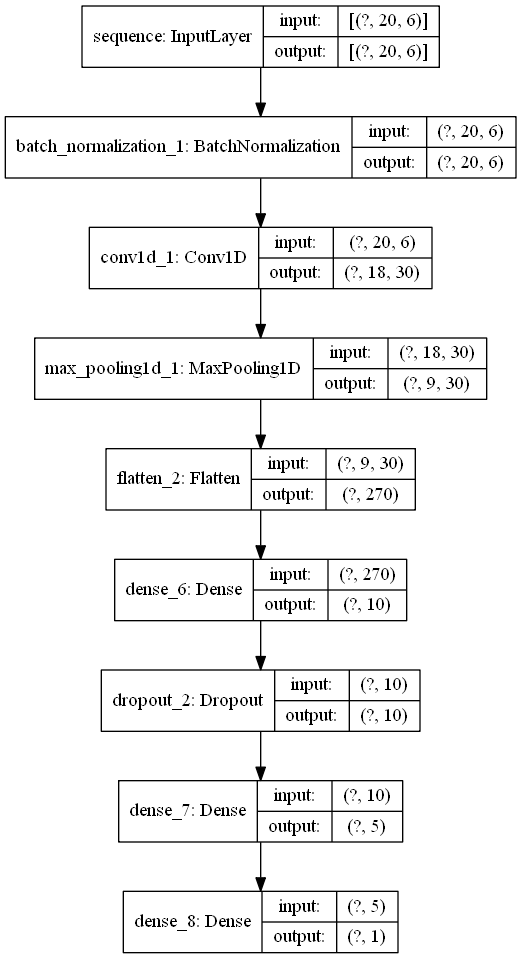

In [29]:
model = create_attention_model()
tf.keras.utils.plot_model(
    model, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    min_delta=0.001, 
    patience=50, 
    verbose=1, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)
model.fit(train_dataset,
          epochs=500,
          verbose = 2,
          validation_data = val_dataset,
          validation_steps=1,
          steps_per_epoch=10,
          callbacks= [early_stopping]
     )

Train for 10 steps, validate for 1 steps
Epoch 1/500
10/10 - 1s - loss: 3492878.6250 - mae: 1676.1483 - mse: 3492878.5000 - root_mean_squared_error: 1868.9244 - val_loss: 2337356544.0000 - val_mae: 48342.9141 - val_mse: 2337356544.0000 - val_root_mean_squared_error: 48346.2148
Epoch 2/500
10/10 - 0s - loss: 993836.0437 - mae: 831.2608 - mse: 993836.0625 - root_mean_squared_error: 996.9133 - val_loss: 1977437824.0000 - val_mae: 44467.0117 - val_mse: 1977437824.0000 - val_root_mean_squared_error: 44468.3906
Epoch 3/500
10/10 - 0s - loss: 465005.3406 - mae: 548.0489 - mse: 465005.3438 - root_mean_squared_error: 681.9130 - val_loss: 1303217536.0000 - val_mae: 36098.3594 - val_mse: 1303217536.0000 - val_root_mean_squared_error: 36100.1055
Epoch 4/500
10/10 - 0s - loss: 339463.8125 - mae: 463.8607 - mse: 339463.7812 - root_mean_squared_error: 582.6352 - val_loss: 644467968.0000 - val_mae: 25385.6816 - val_mse: 644467968.0000 - val_root_mean_squared_error: 25386.3730
Epoch 5/500
10/10 - 0s - 

10/10 - 0s - loss: 228612.8500 - mae: 360.6097 - mse: 228612.8438 - root_mean_squared_error: 478.1348 - val_loss: 64429.0508 - val_mae: 241.7273 - val_mse: 64429.0508 - val_root_mean_squared_error: 253.8288
Epoch 38/500
10/10 - 0s - loss: 229787.9094 - mae: 361.9309 - mse: 229787.9062 - root_mean_squared_error: 479.3620 - val_loss: 47189.4766 - val_mae: 203.0064 - val_mse: 47189.4766 - val_root_mean_squared_error: 217.2314
Epoch 39/500
10/10 - 0s - loss: 243873.2672 - mae: 373.8427 - mse: 243873.2656 - root_mean_squared_error: 493.8353 - val_loss: 62761.7500 - val_mae: 237.7784 - val_mse: 62761.7500 - val_root_mean_squared_error: 250.5229
Epoch 40/500
10/10 - 0s - loss: 236957.2344 - mae: 366.3292 - mse: 236957.2344 - root_mean_squared_error: 486.7825 - val_loss: 39788.7422 - val_mae: 183.3413 - val_mse: 39788.7422 - val_root_mean_squared_error: 199.4712
Epoch 41/500
10/10 - 0s - loss: 238645.1437 - mae: 368.5636 - mse: 238645.1562 - root_mean_squared_error: 488.5132 - val_loss: 36978.

Epoch 75/500
10/10 - 0s - loss: 63188.1102 - mae: 150.8095 - mse: 63188.1094 - root_mean_squared_error: 251.3725 - val_loss: 138887.9688 - val_mae: 367.2145 - val_mse: 138887.9688 - val_root_mean_squared_error: 372.6768
Epoch 76/500
10/10 - 0s - loss: 66222.5719 - mae: 150.1716 - mse: 66222.5703 - root_mean_squared_error: 257.3375 - val_loss: 147992.8438 - val_mae: 379.4478 - val_mse: 147992.8438 - val_root_mean_squared_error: 384.6984
Epoch 77/500
10/10 - 0s - loss: 64892.9633 - mae: 147.0445 - mse: 64892.9609 - root_mean_squared_error: 254.7410 - val_loss: 149402.6719 - val_mae: 381.3396 - val_mse: 149402.6719 - val_root_mean_squared_error: 386.5264
Epoch 78/500
10/10 - 0s - loss: 60862.9387 - mae: 143.0145 - mse: 60862.9414 - root_mean_squared_error: 246.7042 - val_loss: 162924.6562 - val_mae: 398.7372 - val_mse: 162924.6562 - val_root_mean_squared_error: 403.6393
Epoch 79/500
10/10 - 0s - loss: 56818.9664 - mae: 138.8105 - mse: 56818.9648 - root_mean_squared_error: 238.3673 - val_l

In [32]:
prd = model.predict(train_dataset,steps = 1)
val_prd = model.predict(val_dataset, steps=1)

In [33]:
def plot_diff(prcd,resDf,label):
    real = resDf[list(map(lambda x: f'sp500_Close_{x}',label))].transpose().values
    plotDf = pd.DataFrame(real).tail(len(prcd))
    print(plotDf.shape)
    plotDf['prd_Close'] = prcd
    return plotDf

(780, 1)


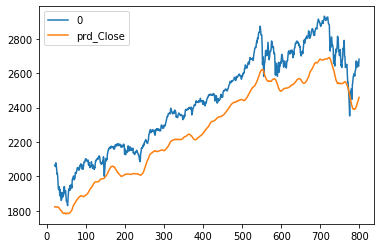

In [34]:
plotDf = plot_diff(prd,psd.df,trainDate)
plotDf.plot()

(80, 1)


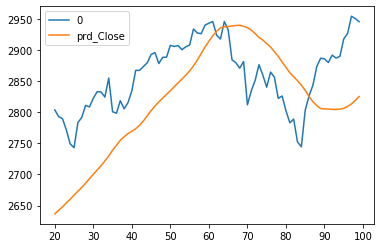

In [35]:
plotDf = plot_diff(val_prd,psd.df,valDate)
plotDf.plot()

In [21]:
tpsd = Pandas_Time_Series_Tensor_Dataset(df)
timeSeriesDic = tpsd.expand_dataFrame_by_date('symbol','Date')
for i,v in enumerate(labels):
    if i == 0:
        tpsd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',testDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        tpsd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',testDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
        
tpsd.set_config(
    name = 'label',
    colNames = list(map(lambda x: f'sp500_Close_{str(x)}',testDate)),
    tensorType = 'label',
    sequence_stack = None,
    isResponseVar = True,
    windowSize = WINDOW_SIZE,
    seqSize = 1837,
    outType = np.float32
)

In [22]:
tgen = psd.make_data_generator()
test_prediction = model.predict(tgen)

In [23]:
plotDf = plot_diff(test_prediction,tpsd.df,testDate)
plotDf.plot()

KeyError: "None of [Index(['sp500_Close_4900', 'sp500_Close_4901', 'sp500_Close_4902',\n       'sp500_Close_4903', 'sp500_Close_4904', 'sp500_Close_4905',\n       'sp500_Close_4906', 'sp500_Close_4907', 'sp500_Close_4908',\n       'sp500_Close_4909', 'sp500_Close_4910', 'sp500_Close_4911',\n       'sp500_Close_4912', 'sp500_Close_4913', 'sp500_Close_4914',\n       'sp500_Close_4915', 'sp500_Close_4916', 'sp500_Close_4917',\n       'sp500_Close_4918', 'sp500_Close_4919', 'sp500_Close_4920',\n       'sp500_Close_4921', 'sp500_Close_4922', 'sp500_Close_4923',\n       'sp500_Close_4924', 'sp500_Close_4925', 'sp500_Close_4926',\n       'sp500_Close_4927', 'sp500_Close_4928', 'sp500_Close_4929',\n       'sp500_Close_4930', 'sp500_Close_4931', 'sp500_Close_4932',\n       'sp500_Close_4933', 'sp500_Close_4934', 'sp500_Close_4935',\n       'sp500_Close_4936', 'sp500_Close_4937', 'sp500_Close_4938',\n       'sp500_Close_4939', 'sp500_Close_4940', 'sp500_Close_4941',\n       'sp500_Close_4942', 'sp500_Close_4943', 'sp500_Close_4944',\n       'sp500_Close_4945', 'sp500_Close_4946', 'sp500_Close_4947',\n       'sp500_Close_4948', 'sp500_Close_4949', 'sp500_Close_4950',\n       'sp500_Close_4951', 'sp500_Close_4952', 'sp500_Close_4953',\n       'sp500_Close_4954', 'sp500_Close_4955', 'sp500_Close_4956',\n       'sp500_Close_4957', 'sp500_Close_4958', 'sp500_Close_4959',\n       'sp500_Close_4960', 'sp500_Close_4961', 'sp500_Close_4962',\n       'sp500_Close_4963', 'sp500_Close_4964', 'sp500_Close_4965',\n       'sp500_Close_4966', 'sp500_Close_4967', 'sp500_Close_4968',\n       'sp500_Close_4969', 'sp500_Close_4970', 'sp500_Close_4971',\n       'sp500_Close_4972', 'sp500_Close_4973', 'sp500_Close_4974',\n       'sp500_Close_4975', 'sp500_Close_4976', 'sp500_Close_4977',\n       'sp500_Close_4978', 'sp500_Close_4979', 'sp500_Close_4980',\n       'sp500_Close_4981', 'sp500_Close_4982', 'sp500_Close_4983',\n       'sp500_Close_4984', 'sp500_Close_4985', 'sp500_Close_4986',\n       'sp500_Close_4987', 'sp500_Close_4988', 'sp500_Close_4989',\n       'sp500_Close_4990', 'sp500_Close_4991', 'sp500_Close_4992',\n       'sp500_Close_4993', 'sp500_Close_4994', 'sp500_Close_4995',\n       'sp500_Close_4996', 'sp500_Close_4997', 'sp500_Close_4998',\n       'sp500_Close_4999'],\n      dtype='object')] are in the [columns]"

In [24]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(plotDf[0],plotDf.prd_High))

AttributeError: 'DataFrame' object has no attribute 'prd_High'